#**GRUPO 7**


##*PREGUNTA 1*

**1.	Determine el momento de inercia de masa del elemento de máquina que se muestra en la figura:

* Al eje x
*	Al eje y
*	Al eje z


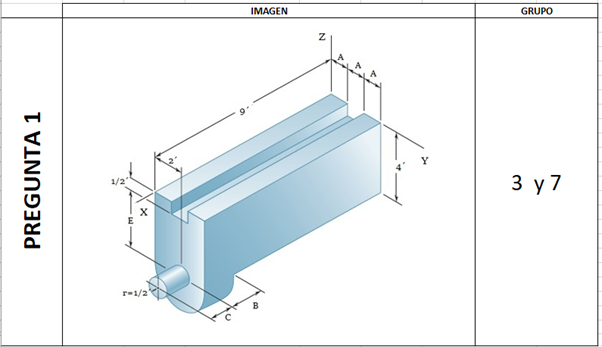


In [ ]:
# @title Ejercicio 1: Código de Momentos de Inercia
import math
from scipy import integrate
import numpy as np

# --- 1. PARÁMETROS DE ENTRADA ---
print("--- CONFIGURACIÓN DE LA PIEZA ---")
# Dimensiones fijas según el plano (en PIES)
Largo_Total_X = 9.0       # 9'
Ancho_Total_Y = 4.0       # 3A = 4' -> A = 1.333'
Altura_Base_Z = 0.5       # 1/2'
Altura_Prisma_Z = 3.5     # E = 4 - 0.5
Altura_Top_Prisma = 4.0   # Altura donde empieza el semicilindro

# Variables de entrada del usuario
# Usa valores por defecto si prefieres no escribirlos cada vez para probar
try:
    B = float(input("Ingrese la longitud B del semicilindro (en pies): "))
    C = float(input("Ingrese la longitud C del cilindro pequeño (en pies): "))
    rho = float(input("Ingrese la densidad del material (en slug/ft³): "))
except ValueError:
    print("Error en los valores. Usando valores de prueba (B=2, C=1, rho=10)")
    B = 2.0
    C = 1.0
    rho = 10.0

print("\n--- INICIANDO CÁLCULO VECTORIAL (INTEGRACIÓN NUMÉRICA) ---")
print("Nota: Esto puede tardar unos segundos por la complejidad de las integrales...")

# --- 2. DEFINICIÓN DE INTEGRALES ---
# Corrección: Ahora pasamos 4 funciones de límites por separado
def calcular_propiedades_region(nombre, x_min, x_max, y_min_f, y_max_f, z_min_f, z_max_f):

    # 1. Masa: Integral de rho dV
    masa, error_m = integrate.tplquad(
        lambda z, y, x: rho,           # Función a integrar
        x_min, x_max,                  # Límites X (constantes)
        y_min_f, y_max_f,              # Límites Y (funciones de x)
        z_min_f, z_max_f               # Límites Z (funciones de x, y)
    )

    # 2. Inercia X: Integral de rho * (y^2 + z^2) dV
    Ix, error_ix = integrate.tplquad(
        lambda z, y, x: rho * (y**2 + z**2),
        x_min, x_max,
        y_min_f, y_max_f,
        z_min_f, z_max_f
    )

    # 3. Inercia Y: Integral de rho * (x^2 + z^2) dV
    Iy, error_iy = integrate.tplquad(
        lambda z, y, x: rho * (x**2 + z**2),
        x_min, x_max,
        y_min_f, y_max_f,
        z_min_f, z_max_f
    )

    # 4. Inercia Z: Integral de rho * (x^2 + y^2) dV
    Iz, error_iz = integrate.tplquad(
        lambda z, y, x: rho * (x**2 + y**2),
        x_min, x_max,
        y_min_f, y_max_f,
        z_min_f, z_max_f
    )

    print(f"   -> Integrando región: {nombre}... Completo.")
    return masa, Ix, Iy, Iz

# --- 3. EJECUCIÓN POR REGIONES GEOMÉTRICAS ---
A = Ancho_Total_Y / 3  # 1.3333 ft

# --- REGIÓN 1: PATAS BASE ---
# Pata Izquierda (Y de 0 a A)
m1, ix1, iy1, iz1 = calcular_propiedades_region(
    "Pata Izquierda",
    0, Largo_Total_X,
    lambda x: 0, lambda x: A,              # Y: 0 a 1.33
    lambda x, y: 0, lambda x, y: Altura_Base_Z # Z: 0 a 0.5
)

# Pata Derecha (Y de 2A a 3A)
m2, ix2, iy2, iz2 = calcular_propiedades_region(
    "Pata Derecha",
    0, Largo_Total_X,
    lambda x: 2*A, lambda x: 3*A,          # Y: 2.66 a 4
    lambda x, y: 0, lambda x, y: Altura_Base_Z # Z: 0 a 0.5
)

# --- REGIÓN 2: PRISMA CENTRAL ---
# Z de 0.5 a 4.0. Y completo de 0 a 3A.
m3, ix3, iy3, iz3 = calcular_propiedades_region(
    "Prisma Central",
    0, Largo_Total_X,
    lambda x: 0, lambda x: Ancho_Total_Y,      # Y: 0 a 4
    lambda x, y: Altura_Base_Z, lambda x, y: Altura_Top_Prisma # Z: 0.5 a 4.0
)

# --- REGIÓN 3: SEMICILINDRO SUPERIOR ---
R_semicil = Ancho_Total_Y / 2 # Radio 2 ft

m4, ix4, iy4, iz4 = calcular_propiedades_region(
    "Semicilindro Superior",
    Largo_Total_X - B, Largo_Total_X,  # X: 9-B a 9
    lambda x: 0, lambda x: Ancho_Total_Y,      # Y: 0 a 4
    # Z va desde la base plana (4.0) hasta la curva
    lambda x, y: Altura_Top_Prisma,
    lambda x, y: Altura_Top_Prisma + np.sqrt(max(0, R_semicil**2 - (y - R_semicil)**2))
    # Nota: Usamos max(0, ...) para evitar errores numéricos de raíz negativa muy pequeños
)

# --- REGIÓN 4: CILINDRO PEQUEÑO (SALIENTE) ---
r_peq = 0.5 # Radio 0.5 ft

m5, ix5, iy5, iz5 = calcular_propiedades_region(
    "Cilindro Saliente",
    Largo_Total_X, Largo_Total_X + C,  # X: 9 a 9+C
    lambda x: R_semicil - r_peq, lambda x: R_semicil + r_peq, # Y: 1.5 a 2.5
    # Z limits
    lambda x, y: Altura_Top_Prisma - np.sqrt(max(0, r_peq**2 - (y - R_semicil)**2)),
    lambda x, y: Altura_Top_Prisma + np.sqrt(max(0, r_peq**2 - (y - R_semicil)**2))
)

# --- 4. SUMATORIA DE RESULTADOS ---
masa_total = m1 + m2 + m3 + m4 + m5
Ix_total = ix1 + ix2 + ix3 + ix4 + ix5
Iy_total = iy1 + iy2 + iy3 + iy4 + iy5
Iz_total = iz1 + iz2 + iz3 + iz4 + iz5

# --- 5. RESULTADOS ---
print("\n" + "="*50)
print(" RESULTADOS FINALES (CÁLCULO VECTORIAL)")
print("="*50)
print(f" Densidad: {rho} slug/ft³")
print(f" Masa Total calculada: {masa_total:.4f} slugs")
print("-" * 50)
print(f" Momento de Inercia Ix (eje x): {Ix_total:.4f} slug·ft²")
print(f" Momento de Inercia Iy (eje y): {Iy_total:.4f} slug·ft²")
print(f" Momento de Inercia Iz (eje z): {Iz_total:.4f} slug·ft²")
print("="*50)

--- CONFIGURACIÓN DE LA PIEZA ---


##*PREGUNTA 2*

**2.	Calcular el producto de inercia del área mostrada en la figura con respecto a los ejes centroidales

*	Al eje x
*	Al eje y



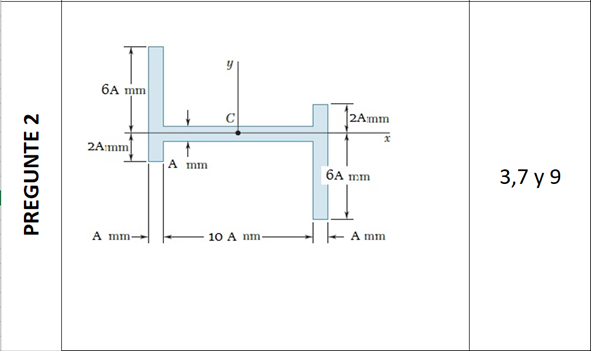

In [ ]:
# @title Ejercicio 2: Código de Producto de Inercia
from scipy.integrate import dblquad

# --- 1. FUNCIÓN DE SELECCIÓN DE MATERIAL ---
def densidad_material():
    print("\n--- SELECCIÓN DE MATERIAL ---")
    print("1. Aluminio (2700 kg/m^3)")
    print("2. Cobre (8960 kg/m^3)")
    print("3. Acero (7850 kg/m^3)")
    print("4. Personalizado")

    try:
        op = int(input("Opción: "))
        if op == 1: return 2700
        elif op == 2: return 8960
        elif op == 3: return 7850
        elif op == 4: return float(input("Densidad (kg/m^3): "))
    except:
        pass
    print("Opción inválida. Usando Aluminio (2700).")
    return 2700

# --- 2. CONFIGURACIÓN ---
print("--- CÁLCULO DE PRODUCTO DE INERCIA (Ixy) ---")
try:
    A = float(input("Ingrese el valor de A (mm): "))
except:
    A = 10.0
    print("Usando A=10mm por defecto.")

rho = densidad_material()

print(f"\n{'REGIÓN':<25} | {'Ixy (mm^4)':<15}")
print("-" * 45)

# --- 3. CÁLCULO EXPLÍCITO POR REGIONES (con función dblquad) ---

# --- REGIÓN 1: Ala Izquierda (Azul) ---
# Límites: x de -6A a -5A; y de -2A a 6A
# Función a integrar: x*y
Ixy_reg1, _ = dblquad(
    lambda y, x: x*y,          # Función
    -6*A, -5*A,                # Límites X
    lambda x: -2*A, lambda x: 6*A # Límites Y (funciones de x)
)
print(f"{'1. Ala Izquierda':<25} | {Ixy_reg1:15.2f}")


# --- REGIÓN 2: Alma Central (Rojo) ---
# Límites: x de -5A a 5A; y de -0.5A a 0.5A
Ixy_reg2, _ = dblquad(
    lambda y, x: x*y,
    -5*A, 5*A,
    lambda x: -0.5*A, lambda x: 0.5*A
)
print(f"{'2. Alma Central':<25} | {Ixy_reg2:15.2f}")


# --- REGIÓN 3: Ala Derecha (Verde) ---
# Límites: x de 5A a 6A; y de -6A a 2A
Ixy_reg3, _ = dblquad(
    lambda y, x: x*y,
    5*A, 6*A,
    lambda x: -6*A, lambda x: 2*A
)
print(f"{'3. Ala Derecha':<25} | {Ixy_reg3:15.2f}")


# --- 4. RESULTADOS FINALES ---
Ixy_total = Ixy_reg1 + Ixy_reg2 + Ixy_reg3
Ixy_teorico = -176 * A**4

print("-" * 45)
print(f"Total Ixy (Función dblquad): {Ixy_total:.2f} mm^4")
print(f"Total Ixy (Teórico -176A^4): {Ixy_teorico:.2f} mm^4")
print("-" * 45)

# --- 5. EXPLICACIÓN DE PROPIEDAD MÁSICA ---
# Fórmula: I_masa = I_area * Longitud * Densidad
# Conversión: mm^4 a m^4 es multiplicar por 10^-12
Ixy_masa = (Ixy_total * 1e-12) * 1.0 * rho

print(f"PROPIEDADES FÍSICAS (Densidad: {rho} kg/m^3):")
print(f"Producto de Inercia de Masa: {Ixy_masa:.4e} kg·m^2")
# Explicación breve:
# 1. Tomamos el Ixy geométrico calculado (mm^4).
# 2. Lo convertimos a metros (x 1e-12).
# 3. Asumimos que la pieza tiene 1 metro de profundidad (eje Z).
# 4. Multiplicamos por la densidad del material elegido.

--- CÁLCULO DE PRODUCTO DE INERCIA (Ixy) ---
Ingrese el valor de A (mm): 10

--- SELECCIÓN DE MATERIAL ---
1. Aluminio (2700 kg/m^3)
2. Cobre (8960 kg/m^3)
3. Acero (7850 kg/m^3)
4. Personalizado
Opción: 1

REGIÓN                    | Ixy (mm^4)     
---------------------------------------------
1. Ala Izquierda          |      -880000.00
2. Alma Central           |            0.00
3. Ala Derecha            |      -880000.00
---------------------------------------------
Total Ixy (Función dblquad): -1760000.00 mm^4
Total Ixy (Teórico -176A^4): -1760000.00 mm^4
---------------------------------------------
PROPIEDADES FÍSICAS (Densidad: 2700 kg/m^3):
Producto de Inercia de Masa: -4.7520e-03 kg·m^2
